In [1]:
import warnings
warnings.filterwarnings('ignore')

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

import torch
from torch import nn
import numpy as np
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import tqdm
import glob
import itertools
import pickle
import gc
import json
from torch.utils.data import Dataset, DataLoader

RUN_NAME = 'Run03'
PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

In [6]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of CAMELS-US catmt's: 395


In [ ]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score

In [4]:
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

REGIONMASKS = {huc: torch.load(f"{PROJECT_DIR}/lumped_training_samples/regionmask/CAMELS-US/HUC{huc}.pt").numpy() for huc in HUCs}

for huc, mask in REGIONMASKS.items():
    print(f"HUC{huc}: {mask.sum()} ({mask.shape[0]})")

HUC01: 12 (395)
HUC02: 39 (395)
HUC03: 45 (395)
HUC04: 16 (395)
HUC05: 26 (395)
HUC06: 10 (395)
HUC07: 26 (395)
HUC08: 10 (395)
HUC09: 5 (395)
HUC10: 52 (395)
HUC11: 26 (395)
HUC12: 28 (395)
HUC13: 4 (395)
HUC14: 5 (395)
HUC15: 12 (395)
HUC16: 6 (395)
HUC17: 52 (395)
HUC18: 21 (395)


In [2]:
from matplotlib import category
import numpy as np
import os
import xarray as xr

import matplotlib.pyplot as plt

# CAMELS-US

In [6]:
param_V = 3
param_L = 1
param_C = 1
suffix = 'pred_glofas' # 'pred_gauge' or 'glofas_gauge' or 'pred_glofas'
varname = 'NSE'
lead_time = 1
min_max = None
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

In [7]:
# all_upa --> np.log(camels_graph['area_geospa_fabric'])
all_upa = []
all_upa_orig = []
all_noflows = []
all_noflows_threshold = []

all_orig = []
all_clipped = []
colors = []

category_positive = 0
category_negative = 0
category_extreme_negative = 0

huc_boundaries = {}
current_index = 0
huc_centers = {}

y_sim = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'y_ground_truth.npy'))[:, lead_time - 1, :] # (num_samples, num_catmts)

for huc in itertools.islice(HUCs, 0, None, 1):
    camels_huc = camels_graph.loc[REGIONMASKS[huc].astype(bool)]
    upa_ori = camels_huc['area_geospa_fabric']
    all_upa_orig.extend(upa_ori.tolist())
    upa = np.log(camels_huc['area_geospa_fabric'])
    all_upa.extend(upa.tolist())

    y_sim_huc = y_sim[:, REGIONMASKS[huc].astype(bool)]
    # no-flow is fraction of time steps with zero flow
    noflows = np.sum(y_sim_huc == 0, axis=0) / y_sim_huc.shape[0]
    noflows_threshold = np.sum(y_sim_huc < 1.0, axis=0) / y_sim_huc.shape[0] # threshold of 1.0 cms
    all_noflows.extend(noflows.tolist())
    all_noflows_threshold.extend(noflows_threshold.tolist())

    ds = xr.open_dataset(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'metrics_{suffix}.nc'))
    huc_mask = REGIONMASKS[huc]
    huc_mask = np.where(huc_mask)[0]
    # Decrease each index by one
    huc_mask = huc_mask + 1
    # Use huc_mask to filter the dataset on dimension 'catmt_idx'
    ds = ds.sel(catmt_idx=huc_mask)
    # Get the metric values for the chosen lead time and variable; flatten them to 1D array
    arr = ds.sel(lead_time=lead_time)[varname].values.flatten()
    n = len(arr)
    # Record the start and end indices for this HUC group
    huc_boundaries[huc] = (current_index, current_index + n)

    for val in arr:
        all_orig.append(val)
        if val < -10:
            clipped = -1
            colors.append('red')
            category_extreme_negative += 1
        else:
            clipped = np.clip(val, -1, 1)
            if clipped < 0:
                colors.append('orange')
                category_negative += 1
            else:
                colors.append('blue')
                category_positive += 1
        all_clipped.append(float(clipped))
    
    current_index += n

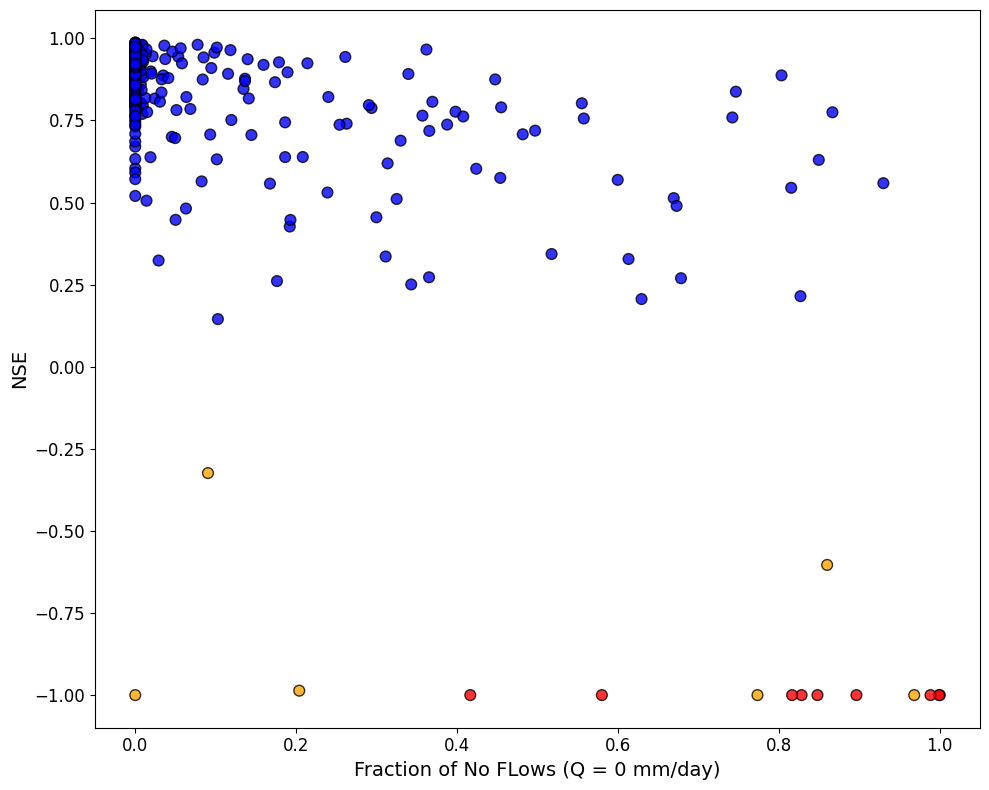

In [9]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q = 0 mm/day)", fontsize=14)
plt.ylabel(varname, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

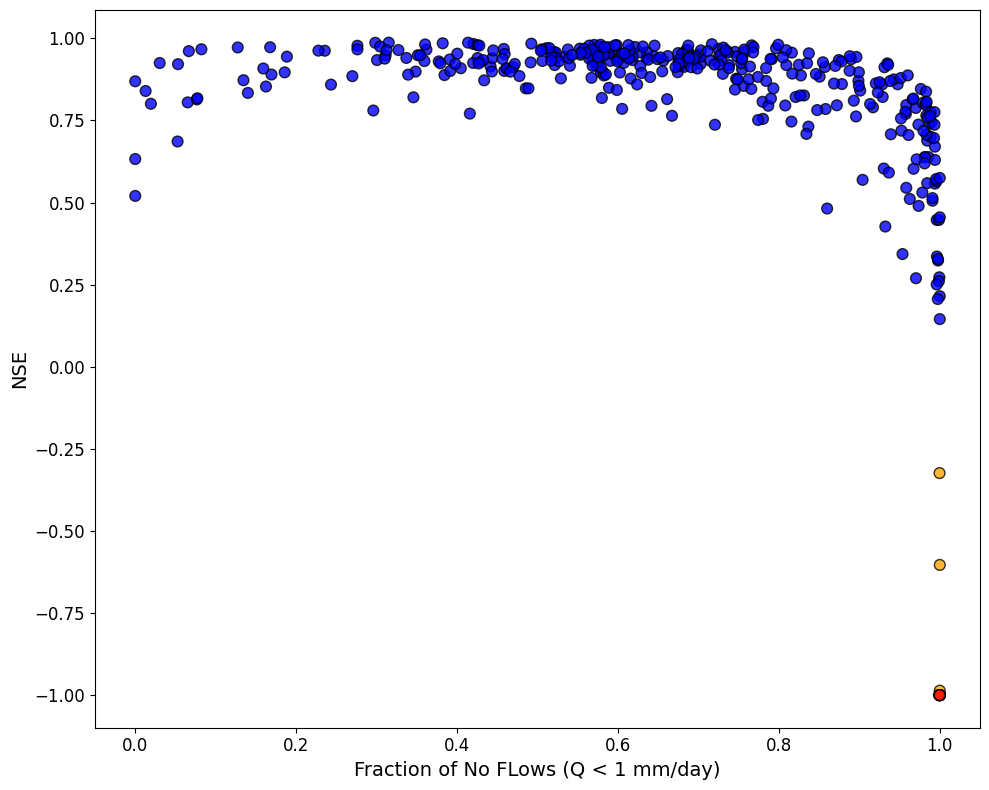

In [10]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
# plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q < 1 mm/day)", fontsize=14)
plt.ylabel(varname, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Hysets

In [16]:
ds = xr.open_dataset('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/hysets/US_hysets_03_retraining_v1_train.nc')
ds

<xarray.Dataset> Size: 1GB
Dimensions:           (lead_time: 10, catmt_idx: 5149, time_idx: 3275)
Coordinates:
  * time_idx          (time_idx) int64 26kB 0 1 2 3 4 ... 3271 3272 3273 3274
  * lead_time         (lead_time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * catmt_idx         (catmt_idx) int64 41kB 0 1 2 3 4 ... 5145 5146 5147 5148
Data variables: (12/15)
    RMSE              (lead_time, catmt_idx) float64 412kB ...
    PearsonR          (lead_time, catmt_idx) float64 412kB ...
    NSE               (lead_time, catmt_idx) float64 412kB ...
    KGE               (lead_time, catmt_idx) float64 412kB ...
    PBIAS             (lead_time, catmt_idx) float64 412kB ...
    alpha_NSE         (lead_time, catmt_idx) float64 412kB ...
    ...                ...
    FDC_FLV           (lead_time, catmt_idx) float64 412kB ...
    mean_peak_timing  (lead_time, catmt_idx) float64 412kB ...
    missed_peaks      (lead_time, catmt_idx) float64 412kB ...
    F1_score          (lead_time, catmt_idx) float64 412kB ...
    y_pred            (time_idx, lead_time, catmt_idx) float32 675MB ...
    y_true            (time_idx, lead_time, catmt_idx) float32 675MB ...

In [17]:
y_sim = ds['y_true'].sel(lead_time=0).values # (num_samples, num_catmts)
print(y_sim.shape)

noflows = np.sum(y_sim == 0, axis=0) / y_sim.shape[0]
noflows_threshold = np.sum(y_sim < 1.0, axis=0) / y_sim.shape[0] # threshold of 1.0 cms

all_noflows = noflows.tolist()
all_noflows_threshold = noflows_threshold.tolist()

print(len(all_noflows))
print(len(all_noflows_threshold))

arr = ds.sel(lead_time=0)['NSE'].values.flatten()
all_orig = []
all_clipped = []
colors = []
for val in arr:
    all_orig.append(val)
    if val < -10:
        clipped = -1
        colors.append('red')
    else:
        clipped = np.clip(val, -1, 1)
        if clipped < 0:
            colors.append('orange')
        else:
            colors.append('blue')
    all_clipped.append(float(clipped))

print(len(all_orig))
print(len(all_clipped))
print(len(colors))

(3275, 5149)
5149
5149
5149
5149
5149


In [ ]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q = 0 mm/day)", fontsize=14)
plt.ylabel('NSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
# plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

# First plot the blue points, then orange, then red to ensure visibility
blue_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'blue']
blue_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'blue']
plt.scatter(blue_x, blue_y, c='blue', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')
orange_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'orange']
orange_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'orange']
plt.scatter(orange_x, orange_y, c='orange', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')
red_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'red']
red_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'red']
plt.scatter(red_x, red_y, c='red', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q < 1 mm/day)", fontsize=14)
plt.ylabel('NSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# CAMELS-IND

In [21]:
ds = xr.open_dataset('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/Revised_Figure05/v1_surr_camelsind_test_metrics.nc')
ds

<xarray.Dataset> Size: 50MB
Dimensions:           (lead_time: 10, catmt_idx: 191, time_idx: 3275)
Coordinates:
  * time_idx          (time_idx) int64 26kB 0 1 2 3 4 ... 3271 3272 3273 3274
  * lead_time         (lead_time) int64 80B 0 1 2 3 4 5 6 7 8 9
  * catmt_idx         (catmt_idx) int64 2kB 0 1 2 3 4 5 ... 186 187 188 189 190
Data variables: (12/15)
    RMSE              (lead_time, catmt_idx) float64 15kB ...
    PearsonR          (lead_time, catmt_idx) float64 15kB ...
    NSE               (lead_time, catmt_idx) float64 15kB ...
    KGE               (lead_time, catmt_idx) float64 15kB ...
    PBIAS             (lead_time, catmt_idx) float64 15kB ...
    alpha_NSE         (lead_time, catmt_idx) float64 15kB ...
    ...                ...
    FDC_FLV           (lead_time, catmt_idx) float64 15kB ...
    mean_peak_timing  (lead_time, catmt_idx) float64 15kB ...
    missed_peaks      (lead_time, catmt_idx) float64 15kB ...
    F1_score          (lead_time, catmt_idx) float64 15kB ...
    y_pred            (time_idx, lead_time, catmt_idx) float32 25MB ...
    y_true            (time_idx, lead_time, catmt_idx) float32 25MB ...

In [22]:
y_sim = ds['y_true'].sel(lead_time=0).values # (num_samples, num_catmts)
print(y_sim.shape)

noflows = np.sum(y_sim == 0, axis=0) / y_sim.shape[0]
noflows_threshold = np.sum(y_sim < 1.0, axis=0) / y_sim.shape[0] # threshold of 1.0 cms

all_noflows = noflows.tolist()
all_noflows_threshold = noflows_threshold.tolist()

print(len(all_noflows))
print(len(all_noflows_threshold))

arr = ds.sel(lead_time=0)['NSE'].values.flatten()
all_orig = []
all_clipped = []
colors = []
for val in arr:
    all_orig.append(val)
    if val < -10:
        clipped = -1
        colors.append('red')
    else:
        clipped = np.clip(val, -1, 1)
        if clipped < 0:
            colors.append('orange')
        else:
            colors.append('blue')
    all_clipped.append(float(clipped))

print(len(all_orig))
print(len(all_clipped))
print(len(colors))

(3275, 191)
191
191
191
191
191


In [ ]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q = 0 mm/day)", fontsize=14)
plt.ylabel('NSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
# plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

# First plot the blue points, then orange, then red to ensure visibility
blue_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'blue']
blue_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'blue']
plt.scatter(blue_x, blue_y, c='blue', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')
orange_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'orange']
orange_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'orange']
plt.scatter(orange_x, orange_y, c='orange', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')
red_x = [all_noflows_threshold[i] for i in range(len(all_clipped)) if colors[i] == 'red']
red_y = [all_clipped[i] for i in range(len(all_clipped)) if colors[i] == 'red']
plt.scatter(red_x, red_y, c='red', edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q < 1 mm/day)", fontsize=14)
plt.ylabel('NSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()